Warning message:
“ 3 failed to parse.”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <b0>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <80>”
Warning 

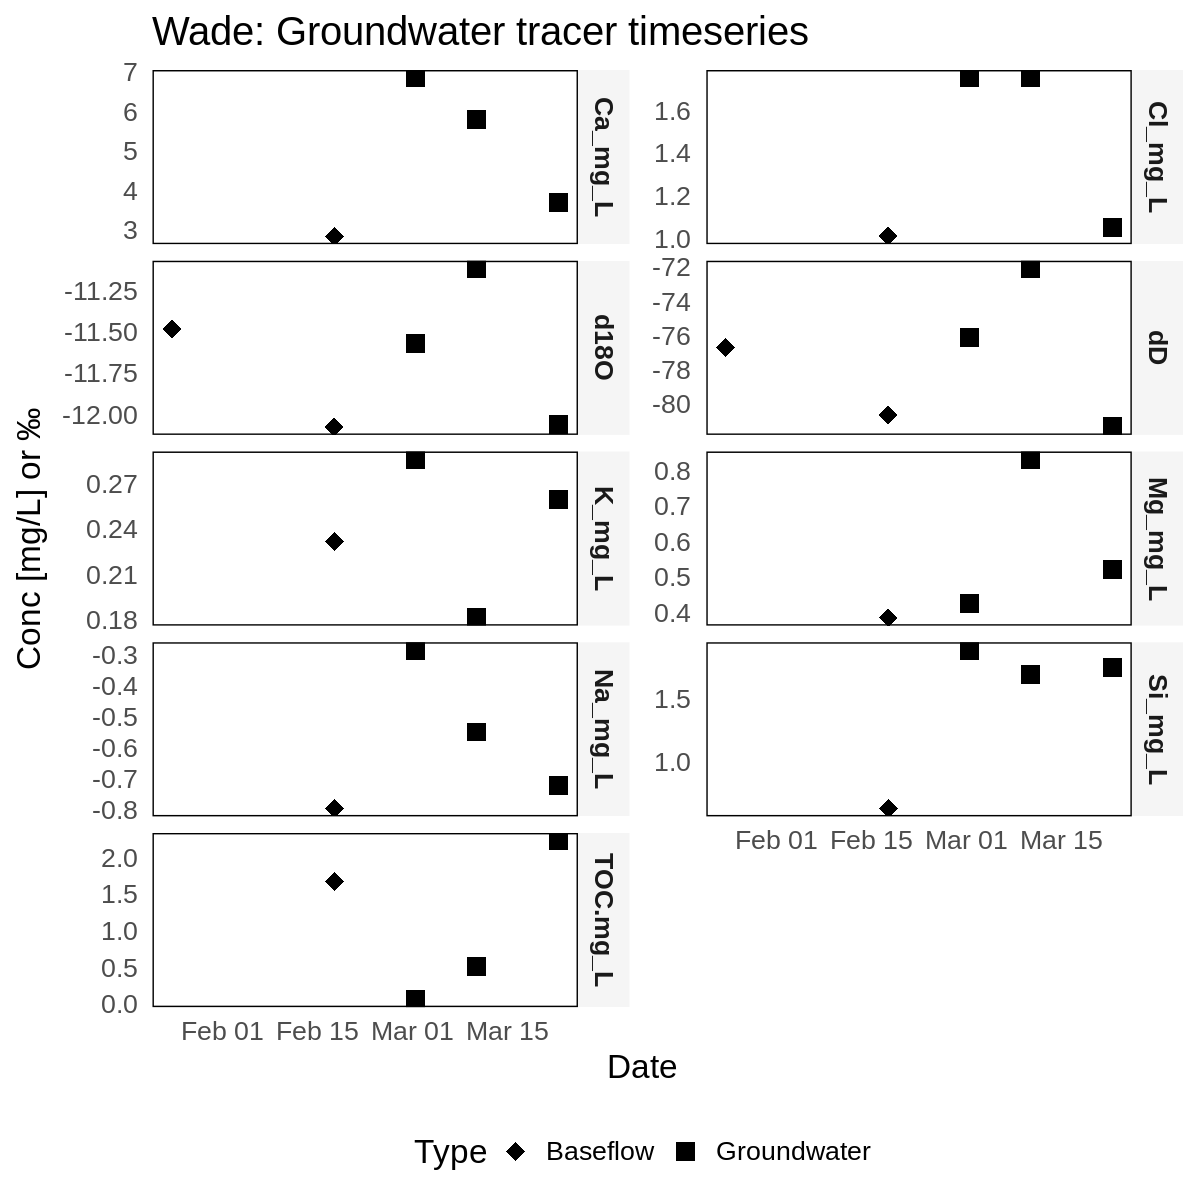

In [3]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(patchwork)

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputData <- read.csv(file.path(input_dir, "RI23-IC-ICP-isotope-toc-joined.csv")) 

InputData <- InputData %>% # Will fix this, but some endmembers misslabeled
  mutate(Type = case_when(
    Type == "Snow lysimeter" ~ "Snowmelt lysimeter",
    TRUE ~ Type
  ))

# Convert missing values to NA
InputData[InputData == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputData$datetime <- mdy_hm(paste(InputData$Date, InputData$Time)) 

# Convert 'datetime' in InputDataQ to proper datetime format
InputData$datetime <- as.POSIXct(InputData$datetime, format="%Y-%m-%dT%H:%M:%SZ")

###############################################################################
################## PLOT ENDMEMBER VARIABILITY IN TIME #########################
###############################################################################

# Step 1: Define tracer list and sample types to keep
tracers <- c("Na_mg_L", "Si_mg_L", "Ca_mg_L", "Mg_mg_L", 
             "K_mg_L", "Cl_mg_L", "dD", "d18O", "TOC.mg_L")

endmember_types <- c(
  #"Soil water lysimeter dry",
  #"Soil water lysimeter wet",
  #"Snowmelt lysimeter",  # Already renamed from "Snow lysimeter"
  #"Snow",
  #"Rain",
  #"Precip",
  "Groundwater",
  #"Ravindra deep groundwater",
  "Baseflow",
  "Pre-event"
)

# Step 2: Filter and pivot data into long format
InputData_long <- InputData %>%
  filter(Type %in% endmember_types) %>%
  select(Site, datetime, Type, all_of(tracers)) %>%
  pivot_longer(
    cols = all_of(tracers),
    names_to = "tracer",
    values_to = "value"
  ) %>%
  mutate(
    value = as.numeric(value),
    Type = trimws(Type)
  )

# Step 3: Define colors and shapes (same as earlier)
custom_colors <- c(
  "Soil water lysimeter dry" = "black",
  "Soil water lysimeter wet" = "#4F4F4F",
  "Groundwater" = "black",
  "Precip" = "grey",
  "Rain" = "grey",
  "Snowmelt lysimeter" = "black",
  "Baseflow" = "black",
  "Pre-event" = "black",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "black"
)

custom_shapes <- c(
  "Soil water lysimeter dry" = 23,
  "Soil water lysimeter wet" = 17,
  "Groundwater" = 15,
  "Precip" = 17,
  "Rain" = 17,
  "Snowmelt lysimeter" = 19,
  "Baseflow" = 18,
  "Pre-event" = 8,
  "Ravindra deep groundwater" = 19,
  "Snow" = 8
)

# Step 4: Plotting function per site

options(repr.plot.width = 10, repr.plot.height = 10) 

plot_tracer_timeseries <- function(site_name) {
  InputData_long %>%
    filter(Site == site_name) %>%
    ggplot(aes(x = datetime, y = value, color = Type, shape = Type)) +
    geom_point(size = 5, alpha = 1.0) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    facet_wrap(~ tracer, scales = "free_y", ncol = 2, strip.position = "right") +
    labs(
      title = paste0(site_name, ": Groundwater tracer timeseries"),
      x = "Date",
      y = "Conc [mg/L] or ‰"
    ) +
    theme_minimal(base_size = 20) +
theme(
  panel.grid = element_blank(),                 # Removes all grid lines
  strip.text = element_text(face = "bold"),
  legend.position = "bottom",
  panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),  # Boxes around facets
  strip.background = element_rect(fill = "#f5f5f5", color = NA)              # Optional: soft background behind facet labels
)
}

# Step 5: Create plots for each site
plot_hungerford <- plot_tracer_timeseries("Hungerford")
plot_wade <- plot_tracer_timeseries("Wade")

# Optionally: Display them one after the other
plot_wade

In [4]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(patchwork)

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"
output_dir <- "output/tracer_timeseries/"

# Create directory if missing
if (!dir.exists(output_dir)) dir.create(output_dir, recursive = TRUE)

################
# READ IN DATA #
################

InputData <- read.csv(file.path(input_dir, "RI23-IC-ICP-isotope-toc-joined.csv")) 

InputData <- InputData %>%
  mutate(Type = case_when(
    Type == "Snow lysimeter" ~ "Snowmelt lysimeter",
    TRUE ~ Type
  ))

# Convert missing values to NA
InputData[InputData == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputData$datetime <- mdy_hm(paste(InputData$Date, InputData$Time)) 
InputData$datetime <- as.POSIXct(InputData$datetime, format="%Y-%m-%dT%H:%M:%SZ")

###############################################################################
################## PLOT ENDMEMBER VARIABILITY IN TIME #########################
###############################################################################

# --- Define tracer list ---
tracers <- c("Na_mg_L", "Si_mg_L", "Ca_mg_L", "Mg_mg_L", 
             "K_mg_L", "Cl_mg_L", "dD", "d18O", "TOC.mg_L")

# --- Define sample-type groups ---
sample_groups <- list(
  groundwater = c("Groundwater", "Baseflow", "Pre-event"),
  soil_water  = c("Soil water lysimeter dry", "Soil water lysimeter wet"),
  meltwater   = c("Snowmelt lysimeter", "Snow")
)

# --- Define colors and shapes ---
custom_colors <- c(
  "Soil water lysimeter dry" = "black",
  "Soil water lysimeter wet" = "#4F4F4F",
  "Groundwater" = "black",
  "Precip" = "grey",
  "Rain" = "grey",
  "Snowmelt lysimeter" = "black",
  "Baseflow" = "black",
  "Pre-event" = "black",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "black"
)

custom_shapes <- c(
  "Soil water lysimeter dry" = 23,
  "Soil water lysimeter wet" = 17,
  "Groundwater" = 15,
  "Precip" = 17,
  "Rain" = 17,
  "Snowmelt lysimeter" = 19,
  "Baseflow" = 18,
  "Pre-event" = 8,
  "Ravindra deep groundwater" = 19,
  "Snow" = 8
)

###############################################################################
######################## PLOTTING FUNCTION ####################################
###############################################################################

plot_tracer_timeseries <- function(site_name, type_group = "groundwater") {
  
  # Check valid group name
  if (!type_group %in% names(sample_groups)) {
    stop(paste("Invalid type_group. Choose one of:", paste(names(sample_groups), collapse = ", ")))
  }
  
  endmember_types <- sample_groups[[type_group]]
  
  # Filter and reshape data
  InputData_long <- InputData %>%
    filter(Type %in% endmember_types) %>%
    select(Site, datetime, Type, all_of(tracers)) %>%
    pivot_longer(cols = all_of(tracers),
                 names_to = "tracer",
                 values_to = "value") %>%
    mutate(value = as.numeric(value),
           Type = trimws(Type))
  
  # Create plot
  p <- InputData_long %>%
    filter(Site == site_name) %>%
    ggplot(aes(x = datetime, y = value, color = Type, shape = Type)) +
    geom_point(size = 5, alpha = 1.0) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    facet_wrap(~ tracer, scales = "free_y", ncol = 2, strip.position = "right") +
    labs(
      title = paste0(site_name, ": ", str_to_title(type_group), " tracer timeseries"),
      x = "Date",
      y = "Conc [mg/L] or ‰"
    ) +
    theme_minimal(base_size = 20) +
    theme(
      panel.grid = element_blank(),
      strip.text = element_text(face = "bold"),
      legend.position = "bottom",
      panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),
      strip.background = element_rect(fill = "#f5f5f5", color = NA)
    )
  
  # Save out the plot
  output_file <- file.path(output_dir, paste0(site_name, "_", type_group, ".jpg"))
  ggsave(output_file, p, width = 10, height = 10, dpi = 300)
  
  message("✅ Saved: ", output_file)
  
  return(p)
}

###############################################################################
######################## EXAMPLE USE ##########################################
###############################################################################

# Create and save plots
plot_hungerford_gw <- plot_tracer_timeseries("Hungerford", type_group = "groundwater")
plot_wade_gw       <- plot_tracer_timeseries("Wade",       type_group = "groundwater")

# Or soil water:
# plot_hungerford_sw <- plot_tracer_timeseries("Hungerford", type_group = "soil_water")

# Or meltwater:
# plot_hungerford_melt <- plot_tracer_timeseries("Hungerford", type_group = "meltwater")

Warning message:
“ 3 failed to parse.”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
✅ Saved: output/tracer_timeseries//Hungerford_groundwater.jpg

Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
✅ Saved: output/tracer_timeseries//Wade_groundwater.jpg



In [6]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(patchwork)

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"
output_dir <- "output/tracer_timeseries/"

# Create directory if missing
if (!dir.exists(output_dir)) dir.create(output_dir, recursive = TRUE)

################
# READ IN DATA #
################

InputData <- read.csv(file.path(input_dir, "RI23-IC-ICP-isotope-toc-joined-Wade.csv")) 

# Fix mislabelled snow samples
InputData <- InputData %>%
  mutate(Type = case_when(
    Type == "Snow lysimeter" ~ "Snowmelt lysimeter",
    TRUE ~ Type
  ))

# Convert missing values to NA
InputData[InputData == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputData$datetime <- mdy_hm(paste(InputData$Date, InputData$Time)) 
InputData$datetime <- as.POSIXct(InputData$datetime, format="%Y-%m-%dT%H:%M:%SZ")

###############################################################################
################## PLOT ENDMEMBER VARIABILITY IN TIME #########################
###############################################################################

# --- Define tracers ---
tracers <- c("Na_mg_L", "Si_mg_L", "Ca_mg_L", "Mg_mg_L", 
             "K_mg_L", "Cl_mg_L", "dD", "d18O", "TOC.mg_L")

# --- Define nicer tracer labels ---
tracer_labels <- c(
  "Na_mg_L"   = "Na (mg/L)",
  "Si_mg_L"   = "Si (mg/L)",
  "Ca_mg_L"   = "Ca (mg/L)",
  "Mg_mg_L"   = "Mg (mg/L)",
  "K_mg_L"    = "K (mg/L)",
  "Cl_mg_L"   = "Cl (mg/L)",
  "dD"        = "δ²H (‰)",
  "d18O"      = "δ¹⁸O (‰)",
  "TOC.mg_L"  = "DOC (mg/L)"
)

# --- Define sample-type groups ---
sample_groups <- list(
  groundwater = c("Groundwater", "Baseflow", "Pre-event"),
  soil_water  = c("Soil water lysimeter dry", "Soil water lysimeter wet"),
  meltwater   = c("Snowmelt lysimeter", "Snow")
)

# --- Define colors and shapes ---
custom_colors <- c(
  "Soil water lysimeter dry" = "black",
  "Soil water lysimeter wet" = "#4F4F4F",
  "Groundwater" = "black",
  "Precip" = "grey",
  "Rain" = "grey",
  "Snowmelt lysimeter" = "black",
  "Baseflow" = "black",
  "Pre-event" = "black",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "black"
)

custom_shapes <- c(
  "Soil water lysimeter dry" = 23,
  "Soil water lysimeter wet" = 17,
  "Groundwater" = 15,
  "Precip" = 17,
  "Rain" = 17,
  "Snowmelt lysimeter" = 19,
  "Baseflow" = 18,
  "Pre-event" = 8,
  "Ravindra deep groundwater" = 19,
  "Snow" = 8
)

###############################################################################
######################## PLOTTING FUNCTION ####################################
###############################################################################

plot_tracer_timeseries <- function(site_name, type_group = "groundwater") {
  
  # Check valid group name
  if (!type_group %in% names(sample_groups)) {
    stop(paste("Invalid type_group. Choose one of:", paste(names(sample_groups), collapse = ", ")))
  }
  
  endmember_types <- sample_groups[[type_group]]
  
  # Filter and reshape data
  InputData_long <- InputData %>%
    filter(Type %in% endmember_types) %>%
    select(Site, datetime, Type, all_of(tracers)) %>%
    pivot_longer(cols = all_of(tracers),
                 names_to = "tracer",
                 values_to = "value") %>%
    mutate(value = as.numeric(value),
           Type = trimws(Type))
  
  # Create plot
  p <- InputData_long %>%
    filter(Site == site_name) %>%
    ggplot(aes(x = datetime, y = value, color = Type, shape = Type)) +
    geom_point(size = 5, alpha = 1.0) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    facet_wrap(~ tracer, scales = "free_y", ncol = 2, strip.position = "right",
               labeller = as_labeller(tracer_labels)) +
    labs(
      title = paste0(site_name, ": ", str_to_title(type_group), " tracer timeseries"),
      x = "Date",
      y = "Conc [mg/L] or ‰"
    ) +
    theme_minimal(base_size = 20) +
    theme(
      panel.grid = element_blank(),
      strip.text = element_text(face = "bold"),
      legend.position = "bottom",
      panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),
      strip.background = element_rect(fill = "#f5f5f5", color = NA),
      axis.text.x = element_text(angle = 30, hjust = 1)   # <--- angled x-axis labels
    )
  
  # Save out the plot
  output_file <- file.path(output_dir, paste0(site_name, "_", type_group, ".jpg"))
  ggsave(output_file, p, width = 10, height = 10, dpi = 300)
  
  message("✅ Saved: ", output_file)
  
  return(p)
}

###############################################################################
########################## BATCH EXPORT OPTION ################################
###############################################################################

# Get all unique sites from your dataset
sites <- unique(InputData$Site)

# Loop through all sites and all type_groups
for (s in sites) {
  for (g in names(sample_groups)) {
    # Wrap in try() so that missing data doesn’t break the loop
    try({
      plot_tracer_timeseries(s, g)
    }, silent = TRUE)
  }
}

Warning message:
“ 2 failed to parse.”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
✅ Saved: output/tracer_timeseries//Wade_groundwater.jpg

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
✅ Saved: output/tracer_timeseries//Wade_soil_water.jpg

Warning message:
“Removed 16 rows containing missing values or values outside the scale range (`geom_point()`).”
✅ Saved: output/tracer_timeseries//Wade_meltwater.jpg

